In [8]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
import torch
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sys import path as paths
import time
import os
import geatpy as ea

project_dir = 'D:/用户/桌面/homework/第二学期/6032/DL MOEA/code/Main/'
figures_dir = 'D:/用户/桌面/homework/第二学期/6032/DL MOEA/paper/figures/'  # figures存放的目录
paths.append(project_dir + 'Algorithms')

from GNN_Model import *

## Device Setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

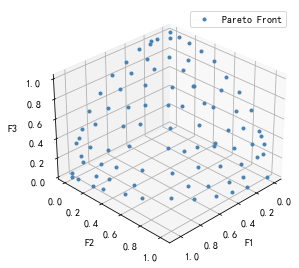

In [9]:
class DTLZ3(ea.Problem):  # 继承Problem父类
    def __init__(self, M):
        name = 'DTLZ3'  # 初始化name（函数名称，可以随意设置）
        maxormins = [1] * M  # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = M + 9  # 初始化Dim（决策变量维数）
        varTypes = [0] * Dim  # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [0] * Dim  # 决策变量下界
        ub = [1] * Dim  # 决策变量上界
        lbin = [1] * Dim  # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim  # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)

    def aimFunc(self, pop):  # 目标函数
        Vars = pop.Phen  # 得到决策变量矩阵
        XM = Vars[:, (self.M - 1):]
        g = 100 * (self.Dim - self.M + 1 + np.sum(((XM - 0.5) ** 2 - np.cos(20 * np.pi * (XM - 0.5))), 1,
                                                  keepdims=True))
        ones_metrix = np.ones((Vars.shape[0], 1))
        f = np.hstack([np.fliplr(np.cumprod(np.cos(Vars[:, :self.M - 1] * np.pi / 2), 1)), ones_metrix]) * np.hstack(
            [ones_metrix, np.sin(Vars[:, range(self.M - 2, -1, -1)] * np.pi / 2)]) * (1 + g)
        pop.ObjV = f  # 把求得的目标函数值赋值给种群pop的ObjV

    def calReferObjV(self):  # 设定目标数参考值（本问题目标函数参考值设定为理论最优值，即“真实帕累托前沿点”）
        uniformPoint, ans = ea.crtup(self.M, 10000)  # 生成10000个在各目标的单位维度上均匀分布的参考点
        referenceObjV = uniformPoint / np.tile(np.sqrt(np.sum(uniformPoint ** 2, 1, keepdims=True)), (1, self.M))
        return referenceObjV


problem = DTLZ3(M=3)  # 生成问题对象
"""==================================种群设置=============================="""
Encoding = 'RI'  # 编码方式
NIND = 100  # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders)  # 创建区域描述器
population = ea.Population(Encoding, Field, NIND)  # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）
"""================================算法参数设置============================="""
# myAlgorithm = ea.moea_MOEAD_DE_templet(problem, population)  # 实例化一个算法模板对象
myAlgorithm = ea.moea_NSGA3_templet(problem, population)  # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 400  # 最大进化代数
myAlgorithm.logTras = 0  # 设置每多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True  # 设置是否打印输出日志信息
myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）
"""==========================调用算法模板进行种群进化=========================
调用run执行算法模板，得到帕累托最优解集NDSet以及最后一代种群。NDSet是一个种群类Population的对象。
NDSet.ObjV为最优解个体的目标函数值；NDSet.Phen为对应的决策变量值。
详见Population.py中关于种群类的定义。
"""
[NDSet, population] = myAlgorithm.run()  # 执行算法模板，得到非支配种群以及最后一代种群

In [10]:
# 训练
data = NDSet.Phen.copy()
Lb = NDSet.Field[0, :]
Ub = NDSet.Field[1, :]
Field = NDSet.Field

start = time.time()
data_set = data_preprocessing(data, Lb, Ub)
network_list = train_net(data_set, epochs=3000, hidden_dim=100*data.shape[1])
end = time.time()
print(end - start)

11.170464992523193


In [11]:
# 预测
total_predicts_data = generate_data(network_list, data_set, Lb, Ub, data.shape[0], NUM=500)
total_predicts_data = ea.boundfix('RI', total_predicts_data, Field)

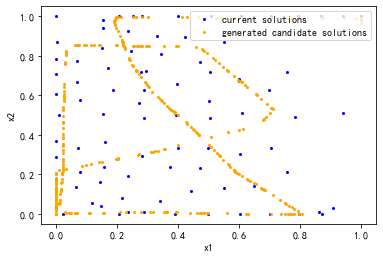

In [13]:
def draw(data, total_predicts_data):
    fig = plt.figure()
    if data.shape[1] == 2:
        plt.plot(data[:, 0], data[:, 1], 'o', markersize=2, color='blue', label='current solutions', )  # 绘制真实数据的图
        plt.plot(total_predicts_data[:, 0], total_predicts_data[:, 1], 'o', markersize=2, color='orange', label='generated candidate solutions')  # 绘制生成的数据的图
        plt.xlabel('x1')
        plt.ylabel('x2')
    elif data.shape[1] == 3:
        ax = fig.gca(projection='3d')
        ax.plot(data[:, 0], data[:, 1], data[:, 2], 'o', markersize=2, color='blue', label='current solutions', )  # 绘制真实数据的图
        ax.plot(total_predicts_data[:, 0], total_predicts_data[:, 1], total_predicts_data[:, 2], 'o', markersize=2, color='orange', label='generated candidate solutions')  # 绘制生成的数据的图
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('x3')
    plt.legend(loc='upper right')
    # plt.savefig(figures_dir + 'DTLZ3_manifold_learning_D123.pdf', dpi=100, bbox_inches='tight')
    plt.show()

# 绘制结果图
draw(data[:, [0,1]], total_predicts_data[:, [0,1]])